In [1]:
# The idea of this notebook is to keep track of averages, etc for some number of past windows (e.g. two past windows). We also
# keep track of peak information in EACH window. When there are no peaks in the most recent past window, then it should dominate
# the forecasting. When it has peaks, it must share forecasting with earlier windows, and so on.

# Note that key_1.csv shows that we are supposed to predict about 2 months worth of future data based on data
# lasting from 2015-07-01 to 2016-12-31.

In [2]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
from sklearn.model_selection import (train_test_split, cross_val_score)
from sklearn.preprocessing import (PolynomialFeatures, FunctionTransformer, StandardScaler)
from sklearn.pipeline import (make_pipeline, make_union, Pipeline, FeatureUnion)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA

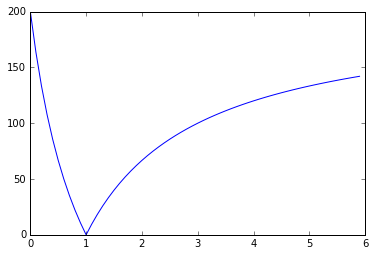

In [3]:
# Reference for performace measured by reference function. For a term |y_test - y_predict| / (|y_test| + |y_predict|) * 2 * 100,
# we look at when y_predict = alpha * y_test. Look at term as a function of alpha.

alpha = np.arange(0.0, 6.0, 0.1)
num = np.abs(1 - alpha)
denom = 1 + np.abs(alpha)
smapeVals = num / denom * 2 * 100

plt.plot(alpha, smapeVals)
plt.show()

In [4]:
all_df = pd.read_csv('train_1.csv')
all_df.shape

(145063, 551)

In [5]:
# For now, just set all NaN to 0.

all_df.fillna(0, inplace = True)

In [6]:
futureT = 64

X_all = all_df.drop('Page', axis = 1).values[:, :-futureT]
Y_all = all_df.drop('Page', axis = 1).values[:, -futureT:]

In [7]:
X_trainvalid, X_test, Y_trainvalid, Y_test = train_test_split(X_all, Y_all, test_size = 0.33, random_state = 32)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_trainvalid, Y_trainvalid, test_size = 0.33, random_state = 35)

print('X_train.shape = ', X_train.shape, '\tX_valid.shape = ', X_valid.shape, '\tX_test.shape = ', X_test.shape)
print('Y_train.shape = ', Y_train.shape, '\tY_valid.shape = ', Y_valid.shape, '\tY_test.shape = ', Y_test.shape)

X_train.shape =  (65118, 486) 	X_valid.shape =  (32074, 486) 	X_test.shape =  (47871, 486)
Y_train.shape =  (65118, 64) 	Y_valid.shape =  (32074, 64) 	Y_test.shape =  (47871, 64)


In [49]:
def smape(Y_predict, Y_test):
    result = np.linalg.norm(Y_predict - Y_test, axis = 1)
    result = np.abs(result)
    denom = np.linalg.norm(Y_predict, axis = 1)
    denom += np.linalg.norm(Y_test, axis = 1)
    result /= denom
    result *= 100 * 2
    result = np.mean(result)
    return result

def smape_scorer(estimator, X, Y):
    Ypredict = estimator.predict(X)
    result = smape(Y, Ypredict)
    return -result

# User should make sure windowSize * nWindows + peakShift doesn't exceed size of axis 1 for X (i.e. the width of X).

def window_features(X, windowSize = 64, nWindows = 2, peakShift = 30):
    Xheight, Xwidth = X.shape
    result = np.empty((Xheight,0))
    
    for i in range(nWindows):
        X_window = X[:, -(i+1) * windowSize -1: -i * windowSize - 1]
        newFeature = np.mean(X_window, axis = 1, keepdims = True)
        result = np.hstack((result, newFeature))
        newFeature = np.std(X_window, axis = 1, keepdims = True)
        result = np.hstack((result, newFeature))
        newFeature = np.dot(X_window, np.arange(windowSize)).reshape(-1,1)
        result = np.hstack((result, newFeature))
        
        peak_window = X_window - X[:, -(i+1) * windowSize - 1 - peakShift : -i * windowSize - 1 - peakShift]
        peak_window = np.abs(peak_window)
        newFeature = np.mean(peak_window, axis = 1, keepdims = True)
        result = np.hstack((result, newFeature))
        newFeature = np.std(peak_window, axis = 1, keepdims = True)
        result = np.hstack((result, newFeature))
        
        peak_window[peak_window > 0] = 1.0
        newFeature = np.sum(peak_window, axis = 1, keepdims = True)
        result = np.hstack((result, newFeature))
        
    return result

In [50]:
# Look at shapes of feature functions.

windowCols = window_features(X_train)

print('X_train.shape = ', X_train.shape)
print('windowCols.shape = ', windowCols.shape)

X_train.shape =  (65118, 486)
windowCols.shape =  (65118, 12)


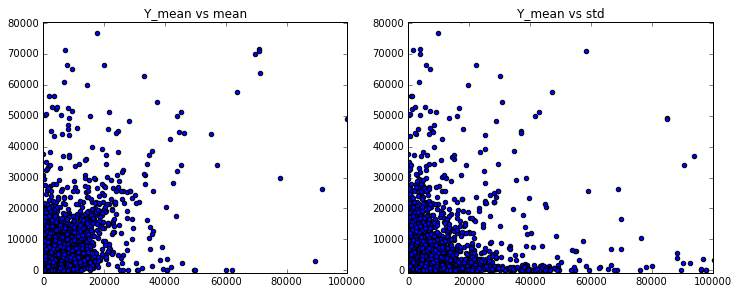

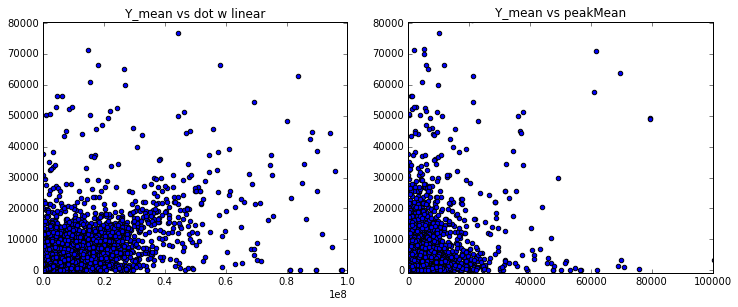

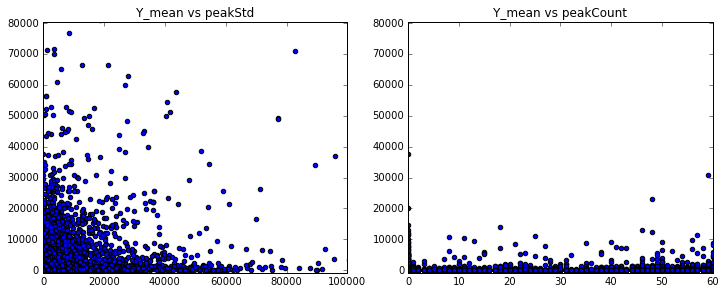

In [154]:
# Let's look at graphs of average future values vs various statistics above.

Y_mean = np.mean(Y_train, axis = 1, keepdims = True)
names = np.array(['mean', 'std', 'dot w linear', 'peakMean', 'peakStd', 'peakCount'])
xlims = np.array([[0, 1e5], [0, 1e5], [0, 1e8], [0, 1e5], [0, 1e5], [0, 60]])
ylims = np.array([[-1e4, 1e5], [-1e4, 5e4], [-1e5, 1e5], [-1e4, 5e4], [-1e4, 5e4], [-1e4,1e5]])
ylims = np.array([np.mean(Y_mean) - 0.1 * np.std(Y_mean), np.mean(Y_mean) + 4*np.std(Y_mean)])
nFeatures = len(names)

names = names.reshape(3,2)
xlims = xlims.reshape(3,2,2)
indices = np.arange(nFeatures).reshape(names.shape)

h, w = names.shape
for i in range(h):
    
    plt.figure(figsize = (12, 4.5))
    
    for j in range(w):
        feature = windowCols[:, indices[i][j]].reshape(-1, 1)
        data = np.hstack((feature, Y_mean))
        plt.subplot('1' + str(w) + str(j+1))
        plt.scatter(feature, Y_mean)
        plt.title('Y_mean vs ' + names[i][j])
        ax = plt.gca()
        ax.set_xlim(xlims[i][j])
        ax.set_ylim(ylims)
        
    plt.show()
        

C:\Users\Matthew\Miniconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\Users\Matthew\Miniconda3\lib\site-packages\numpy\core\_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Matthew\Miniconda3\lib\site-packages\numpy\core\_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
C:\Users\Matthew\Miniconda3\lib\site-packages\numpy\core\_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\Matthew\Miniconda3\lib\site-packages\numpy\core\_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


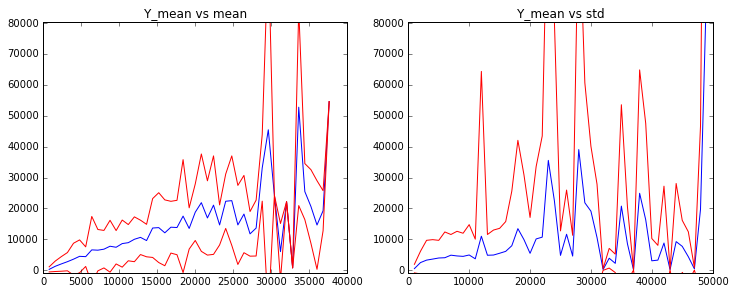

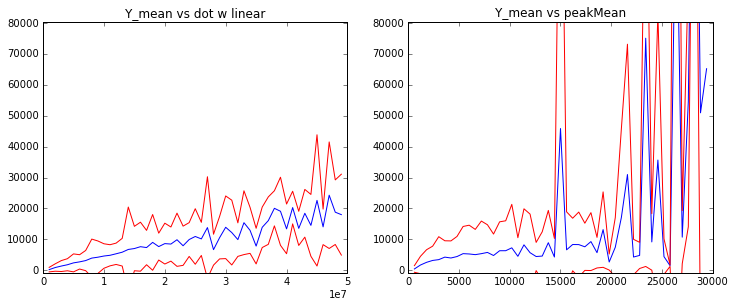

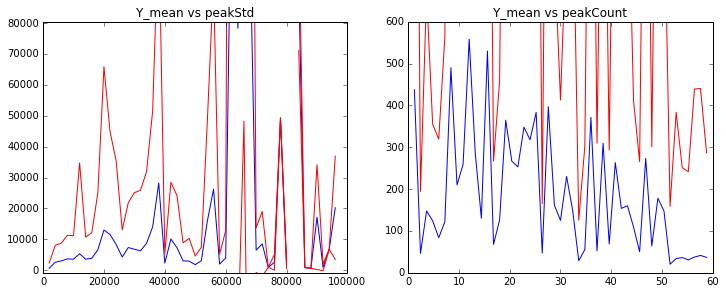

In [162]:
# Let's look at graphs of average future values vs various statistics above.

Y_mean = np.mean(Y_train, axis = 1, keepdims = True)
names = np.array(['mean', 'std', 'dot w linear', 'peakMean', 'peakStd', 'peakCount'])
xlims = np.array([[0, 4e4], [0, 5e4], [0, 5e7], [0, 3e4], [0, 1e5], [0, 60]])
ylims = np.array([[-1e4, 1e5], [-1e4, 5e4], [-1e5, 1e5], [-1e4, 5e4], [-1e4, 5e4], [-1e4,1e5]])
ylims = np.array([np.mean(Y_mean) - 0.1 * np.std(Y_mean), np.mean(Y_mean) + 4*np.std(Y_mean)])
nFeatures = len(names)

names = names.reshape(3,2)
xlims = xlims.reshape(3,2,2)
indices = np.arange(nFeatures).reshape(names.shape)

h, w = names.shape
for i in range(h):
    
    plt.figure(figsize = (12, 4.5))
    
    for j in range(w):
        feature = windowCols[:, indices[i][j]].reshape(-1, 1)
        bins = np.arange(xlims[i][j][0], xlims[i][j][1], (xlims[i][j][1] - xlims[i][j][0]) / 50)
        binIndices = np.digitize(feature, bins)
        binMeans = np.array([Y_mean[binIndices == i].mean() for i in range(len(bins))])
        binStds = np.array([Y_mean[binIndices == i].std() for i in range(len(bins))])
    
        plt.subplot('1' + str(w) + str(j+1))
        plt.plot(bins, binMeans)
        plt.plot(bins, binMeans + binStds, color = 'red')
        plt.plot(bins, binMeans - binStds, color = 'red')
        plt.title('Y_mean vs ' + names[i][j])
        ax = plt.gca()
        ax.set_xlim(xlims[i][j])
        if i == h-1 and j==w-1:
            ylims = [0, 6e2]
        ax.set_ylim(ylims)
        
    plt.show()
        

In [109]:
# Try a simple linear Regression.

linear = LinearRegression()
featuresTr = FunctionTransformer(window_features)
model = Pipeline([ ('windows', featuresTr),
                   ('linear', linear) ])
score = -cross_val_score(model, X_trainvalid, Y_trainvalid, scoring = smape_scorer)
score = np.mean(score)
model.fit(X_trainvalid, Y_trainvalid)
Y_predict = model.predict(X_test)
test_score = smape(Y_predict, Y_test)
print('Cross validation score = ', score, '\tTest Score = ', test_score)

Cross validation score =  130.602127507 	Test Score =  129.182231355


(64, 12)


C:\Users\Matthew\Miniconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\Users\Matthew\Miniconda3\lib\site-packages\numpy\core\_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Matthew\Miniconda3\lib\site-packages\numpy\core\_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
C:\Users\Matthew\Miniconda3\lib\site-packages\numpy\core\_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\Matthew\Miniconda3\lib\site-packages\numpy\core\_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


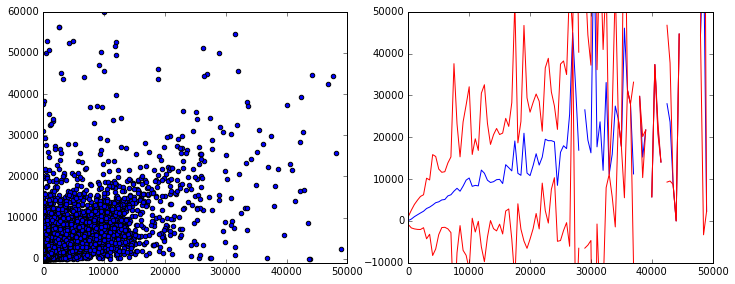

In [143]:
# Let's use the coefficients of linear fit above to find a 1d domain var to map against the mean of Y_train.

print(linear.coef_.shape)
changeVars = np.mean(linear.coef_, axis = 0)
featuresTr.fit(X_train)
features = featuresTr.transform(X_train)
newVar = np.dot(features, changeVars)

bins = np.arange(0, 5e4, 5e4 / 100)
binIndices = np.digitize(newVar, bins)
bin_means = np.array([Y_mean[binIndices == i].mean() for i in range(len(bins)) ])
bin_stds = np.array([Y_mean[binIndices == i].std() for i in range(len(bins)) ])

plt.figure(figsize = (12, 4.5))
plt.subplot(121)
plt.scatter(newVar, Y_mean)
ax = plt.gca()
ax.set_xlim([0, 5e4])
ax.set_ylim([-1e3, 6e4])

plt.subplot(122)
plt.plot(bins, bin_means)
plt.plot(bins, bin_means + 2 * bin_stds, color = 'red')
plt.plot(bins, bin_means - 2 * bin_stds, color = 'red')
ax = plt.gca()
ax.set_ylim([-1e4, 5e4])
plt.show()

In [46]:
# Try a neural network.

model = Pipeline([ ('windows', FunctionTransformer(window_features)),
                   ('poly', PolynomialFeatures(2)),
                   ('neural', MLPRegressor(hidden_layer_sizes = (30, 10))) ])

score = -cross_val_score(model, X_trainvalid, Y_trainvalid, scoring = smape_scorer)
score = np.mean(score)
model.fit(X_trainvalid, Y_trainvalid)
Y_predict = model.predict(X_test)
test_score = smape(Y_predict, Y_test)
print('Cross validation score = ', score, '\tTest Score = ', test_score)

C:\Users\Matthew\Miniconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:565: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\Users\Matthew\Miniconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
C:\Users\Matthew\Miniconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Cross validation score =  194.4586437 	Test Score =  169.088068259
